# 🧠 LP in scipy

In [15]:
from scipy.optimize import linprog
from IPython.display import clear_output

$$
\begin{align*}
&\min_x c^{\top}x \\
\text{s.t. } & Ax \leq b\\
x_2 \geq -3, \qquad &A = \begin{pmatrix}
    -3       & 1\\
    1      & 2
\end{pmatrix} \qquad b = \begin{pmatrix} 6 \\ 4\end{pmatrix}
\end{align*}
$$

In [16]:
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True})

print(res)

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -8.0                
0.09885158404625    0.09885158404625    0.09885158404625    0.903461537018   0.09885158404625    -6.284698425658     
0.05788429348353    0.05788429348355    0.05788429348355    0.4273037994111  0.05788429348355    -7.864724729573     
0.04539867008243    0.04539867008244    0.04539867008244    0.2387091287399  0.04539867008244    -12.78916804766     
0.00666151448168    0.006661514481681   0.006661514481682   0.8665142913493  0.006661514481682   -21.3520715063      
6.299626472385e-06  6.299626472585e-06  6.299626472583e-06  1.0              6.299626472588e-06  -21.99681708159     
3.150192408518e-10  3.150193669765e-10  3.150193217394e-10  0.9999499939647  3.150193297574e-10  -21.99999984082     
Optimization terminated successfully.
         Current fu

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


If you want to build tableaus quickly 😀

In [17]:
import scipy

c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True}, callback=scipy.optimize.linprog_verbose_callback)

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -8.0                
--------- Iteration 0  ---------

0.09885158404625    0.09885158404625    0.09885158404625    0.903461537018   0.09885158404625    -6.284698425658     
--------- Iteration 1  ---------

Current Pseudo-Objective Value:
f =  -6.284698425658357

Current Solution Vector:
x =  [     -0.1505      -1.6088]

0.05788429348353    0.05788429348355    0.05788429348355    0.4273037994111  0.05788429348355    -7.864724729573     
--------- Iteration 2  ---------

Current Pseudo-Objective Value:
f =  -7.864724729572676

Current Solution Vector:
x =  [      3.6474      -1.0543]

0.04539867008243    0.04539867008244    0.04539867008244    0.2387091287399  0.04539867008244    -12.78916804766     
--------- Iteration 3  ---------

Current Pseudo-Objective Value:
f =  -12.78

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# 👨‍🔬 Klee, Minty example, when simplex works slow

In [18]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linprog
import seaborn as sns
sns.set()

def generate_KleeMinty_test_problem(n):
    c = np.array([2**i for i in range(n)])
    c = c[::-1]
    bounds = [(0, None) for i in range(n)]
    b = np.array([5**(i+1) for i in range(n)])
    a = np.array([1] + [2**(i+1) for i in range(1, n)])
    A = np.zeros((n, n))
    for i in range(n):
        A[i:, i] = a[:n-i]
    return -c, A, b, bounds

def generate_random_LP_problem(n):
    c = np.random.rand(n)
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    bounds = []
    for i in range(n):
        bound = (-np.random.rand(1), np.random.rand(1))
        bounds.append(bound)
    return c, A, b, bounds

In [19]:
n = 5
c, A, b, bounds = generate_KleeMinty_test_problem(n)
print(c)
print(A) 
print(b)
print(bounds)

[-16  -8  -4  -2  -1]
[[ 1.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.]
 [ 8.  4.  1.  0.  0.]
 [16.  8.  4.  1.  0.]
 [32. 16.  8.  4.  1.]]
[   5   25  125  625 3125]
[(0, None), (0, None), (0, None), (0, None), (0, None)]


In [20]:
n_list = range(2, 15)

n_iters_km = np.zeros(len(n_list))
times_km   = np.zeros(len(n_list))
n_iters_r  = np.zeros(len(n_list))
times_r    = np.zeros(len(n_list))

for i, n in enumerate(n_list):
    c, A, b, bounds = generate_KleeMinty_test_problem(n)
    # res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 3 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1}, method='simplex')
    # n_iters_km[i] = res.nit
    times_km[i] = np.average(time.all_runs)

    c, A, b, bounds = generate_random_LP_problem(n)
    # res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 3 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1}, method='simplex')
    # n_iters_r[i] = res.nit
    times_r[i] = np.average(time.all_runs)

3 loops, best of 5: 2.19 ms per loop
3 loops, best of 5: 3.45 ms per loop
3 loops, best of 5: 3.83 ms per loop
3 loops, best of 5: 4.9 ms per loop
3 loops, best of 5: 7.5 ms per loop
3 loops, best of 5: 6.38 ms per loop
3 loops, best of 5: 14.6 ms per loop
3 loops, best of 5: 9.45 ms per loop
3 loops, best of 5: 29.3 ms per loop
3 loops, best of 5: 10.8 ms per loop
3 loops, best of 5: 57.9 ms per loop
3 loops, best of 5: 11 ms per loop
3 loops, best of 5: 120 ms per loop
3 loops, best of 5: 14.2 ms per loop
3 loops, best of 5: 244 ms per loop
3 loops, best of 5: 14.8 ms per loop
3 loops, best of 5: 489 ms per loop
3 loops, best of 5: 18.5 ms per loop
3 loops, best of 5: 995 ms per loop
3 loops, best of 5: 29.7 ms per loop
3 loops, best of 5: 2.02 s per loop
3 loops, best of 5: 21.9 ms per loop
3 loops, best of 5: 4.17 s per loop
3 loops, best of 5: 31.6 ms per loop
3 loops, best of 5: 8.28 s per loop
3 loops, best of 5: 30.7 ms per loop


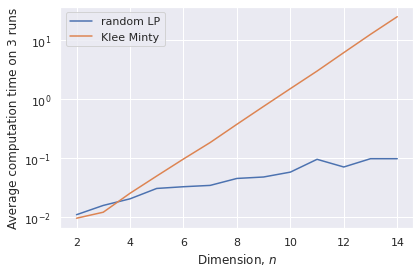

In [21]:
plt.semilogy(n_list, times_r, label='random LP')
plt.semilogy(n_list, times_km, label = 'Klee Minty')
plt.legend()
plt.xlabel("Dimension, $n$")
plt.ylabel("Average computation time on 3 runs")
plt.tight_layout()
plt.savefig('LP_KM.svg')
plt.show()

# 📼 PuLP library example (Optimal watching TED talks)

In [23]:
!pip install pulp --quiet

In [24]:
%matplotlib inline
 
import pulp
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import Image

In [25]:
# Download the dataset from https://www.kaggle.com/rounakbanik/ted-talks

# Read the dataset into pandas dataframe, convert duration from seconds to minutes
ted = pd.read_csv('https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/Notebooks/ted_main.csv', encoding='ISO-8859-1')
ted['duration'] = ted['duration'] / 60
ted = ted.round({'duration': 1})

# Select subset of columns & rows (if required)
# data = ted.sample(n=1000) # 'n' can be changed as required
data = ted
selected_cols = ['name', 'event', 'duration', 'views']
data.reset_index(inplace=True)
data.head()

,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.4,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,1,265,With the same humor and humanity he exuded in ...,16.3,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,2,124,New York Times columnist David Pogue takes aim...,21.4,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,3,200,"In an emotionally charged talk, MacArthur-winn...",18.6,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,4,593,You've never seen data presented like this. Wi...,19.8,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [26]:
# create LP object,
# set up as a maximization problem --> since we want to maximize the number of TED talks to watch
prob = pulp.LpProblem('WatchingTEDTalks', pulp.LpMaximize)

In [27]:
# create decision - yes or no to watch the talk?
decision_variables = []
for rownum, row in data.iterrows():
    variable = str('x' + str(row['index']))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1) # make variable binary
    decision_variables.append(variable)
    
print('Total number of decision variables: ' + str(len(decision_variables)))

Total number of decision variables: 2550


In [28]:
# Create optimization Function
total_views = ''
for rownum, row in data.iterrows():
    for i,talk in enumerate(decision_variables):
        if rownum == i:
            formula = (len(row['description']) + (-1)*row['views']) * talk
            total_views += formula
            
prob += total_views
# print('Optimization function: ' + str(total_views))

In [29]:
# Contraints
total_time_available_for_talks = 3*60 # Total time available is 5 hours . Converted to minutes
total_talks_can_watch = 8 # Don't want an overload information

In [30]:
# Create Constraint 1 - Time for talks
total_time_talks = ''
for rownum, row in data.iterrows():
    for i,  talk in enumerate(decision_variables):
        if rownum == i:
            formula = row['duration']*talk
            total_time_talks += formula
            
prob += (total_time_talks <= total_time_available_for_talks)

In [31]:
# Create Constraint 2 - Number of talks
total_talks = ''

for rownum, row in data.iterrows():
    for i, talk in enumerate(decision_variables):
        if rownum == i:
            formula = talk
            total_talks += formula
            
prob += (total_talks == total_talks_can_watch)

In [32]:
# Be careful, the output will be huge
# print(prob)
prob.writeLP('WatchingTEDTalks.lp')
print('🤔 The problem has successfully formulated')

🤔 The problem has successfully formulated


In [33]:
optimization_result = prob.solve()

assert optimization_result == pulp.LpStatusOptimal
print('Status:', pulp.LpStatus[prob.status])
print('Optimal Solution to the problem: ', pulp.value(prob.objective))
print('Individual decision variables: ')


for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

Status: Optimal
Optimal Solution to the problem:  -784644.0
Individual decision variables: 
x1079 = 1.0
x1112 = 1.0
x1133 = 1.0
x1141 = 1.0
x1229 = 1.0
x237 = 1.0
x594 = 1.0
x776 = 1.0


In [34]:
# reorder results
variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)
    
df = pd.DataFrame({'index': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['index'])
    df.loc[rownum, 'index'] = int(value[0])
    
# df = df.sort_index(by = 'index')
df = df.sort_values(by = 'index')
result = pd.merge(data, df, on = 'index')
result = result[result['value'] == 1].sort_values(by = 'views', ascending = False)
selected_cols_final = ['name', 'event', 'duration', 'views']
final_set_of_talks_to_watch = result[selected_cols_final]

In [35]:
from IPython.display import display, HTML
display(HTML(final_set_of_talks_to_watch.to_html(index=False)))

name,event,duration,views
Leslie Dodson: Don't misrepresent Africa,TEDxBoulder 2011,11.4,121186
Keith Nolan: Deaf in the military,TEDxIslay,18.6,120274
JosÃ© Bowen: Beethoven the businessman,TEDxSMU,12.8,117756
Aleph Molinari: Let's bridge the digital divide!,TEDxSanMigueldeAllende,9.9,115346
Tim Birkhead: The early birdwatchers,The Do Lectures,28.2,112321
"Rokia Traore: ""Kounandi""",TEDGlobal 2007,6.4,82488
Charles Hazlewood + British Paraorchestra: The debut of the British Paraorchestra,TEDxBrussels,13.6,66668
Edwidge Danticat: Stories of Haiti,University of California,59.6,50443


# 🌮 Diet problem with PyOMO

[source](https://nbviewer.jupyter.org/github/Pyomo/PyomoGallery/blob/master/diet/DietProblem.ipynb)

![](https://fmin.xyz/docs/methods/diet_LP.svg)

## Summary

Imagine, that you have to construct a diet plan from some set of products: 🍌🍰🍗🥚🐟. Each of the products has its own vector of nutrients. Thus, all the food information could be processed through the matrix $W$. Let also assume, that we have the vector of requirements for each of nutrients $r \in \mathbb{R}^n$. We need to find the cheapest configuration of the diet, which meets all the requirements:

$$
\begin{align*}
&\min_{x \in \mathbb{R}^p} c^{\top}x \\
\text{s.t. } & Wx \geq r\\
& x_i \geq 0, \; i = 1,\dots, n
\end{align*}
$$


The goal of the Diet Problem is to select foods that satisfy daily nutritional requirements at minimum cost. This problem can be formulated as a linear program, for which constraints limit the number of calories and the amount of vitamins, minerals, fats, sodium, and cholesterol in the diet. Danzig (1990) notes that the diet problem was motivated by the US Army's desire to minimize the cost of feeding GIs in the field while still providing a healthy diet.

## Problem Statement

The Diet Problem can be formulated mathematically as a linear programming problem using the following model.  

### Sets

 $F$ = set of foods  
 $N$ = set of nutrients

### Parameters

 * $c_i$ = cost per serving of food $i$, $\forall i \in F$  
 * $a_{ij}$ = amount of nutrient $j$ in food $i$, $\forall i \in F, \forall j \in N$  
 * $Nmin_j$ = minimum level of nutrient $j$, $\forall j \in N$  
 * $Nmax_j$ = maximum level of nutrient $j$, $\forall j \in N$  
 * $V_i$ = the volume per serving of food $i$, $\forall i \in F$  
 * $Vmax$ = maximum volume of food consumed
 
### Variables
 $x_i$ = number of servings of food $i$ to consume

### Objective

Minimize the total cost of the food  

$$
\min \sum_{i \in F} c_i x_i
$$

### Constraints

Limit nutrient consumption for each nutrient $j \in N$.  
 $Nmin_j \leq \sum_{i \in F} a_{ij} x_i \leq Nmax_j$, $\forall j \in N$

Limit the volume of food consumed  
 $\sum_{i \in F} V_i x_i \leq Vmax$
 
Consumption lower bound  
 $x_i \geq 0$, $\forall i \in F$

### Formulation

$$
\begin{align*}
&\min \sum_{i \in F} c_i x_i\\
\text{s.t. } & Nmin_j \leq \sum_{i \in F} a_{ij} x_i \leq Nmax_j \; \forall j \in N\\
& \sum_{i \in F} V_i x_i \leq Vmax \\
& x_i \geq 0 \; \forall i \in F
\end{align*}
$$


## Pyomo Formulation

We begin by importing the Pyomo package and creating a model object:

In [36]:
!pip install pyomo --quiet

from IPython.display import clear_output

# Installing cbc solver
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

clear_output()

In [37]:
from pyomo.environ import *
infinity = float('inf')

model = AbstractModel()

The sets $F$ and $N$ are declared abstractly using the `Set` component:

In [38]:
# Foods
model.F = Set()
# Nutrients
model.N = Set()

Similarly, the model parameters are defined abstractly using the `Param` component:

In [39]:
# Cost of each food
model.c    = Param(model.F, within=PositiveReals)
# Amount of nutrient in each food
model.a    = Param(model.F, model.N, within=NonNegativeReals)
# Lower and upper bound on each nutrient
model.Nmin = Param(model.N, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.N, within=NonNegativeReals, default=infinity)
# Volume per serving of food
model.V    = Param(model.F, within=PositiveReals)
# Maximum volume of food consumed
model.Vmax = Param(within=PositiveReals)

The `within` option is used in these parameter declarations to define expected properties of the parameters.  This information is used to perform error checks on the data that is used to initialize the parameter components.

The `Var` component is used to define the decision variables:

In [40]:
# Number of servings consumed of each food
model.x = Var(model.F, within=NonNegativeIntegers)

The `within` option is used to restrict the domain of the decision variables to the non-negative reals. This eliminates the need for explicit bound constraints for variables.

The `Objective` component is used to define the cost objective.  This component uses a rule function to construct the objective expression:

In [41]:
# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.F)
model.cost = Objective(rule=cost_rule)

Similarly, rule functions are used to define constraint expressions in the `Constraint` component:

In [42]:
# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.a[i,j]*model.x[i] for i in model.F)
    return inequality(model.Nmin[j], value, model.Nmax[j])
model.nutrient_limit = Constraint(model.N, rule=nutrient_rule)

# Limit the volume of food consumed
def volume_rule(model):
    return sum(model.V[i]*model.x[i] for i in model.F) <= model.Vmax
model.volume = Constraint(rule=volume_rule)

Putting these declarations all together gives the following model:

In [44]:
# Donwloading file locally
!pip install wget
import wget
import os

print('Beginning file download with wget module')

if os.path.exists('LP_diet.py'):
    os.remove('LP_diet.py') 
url = 'https://raw.githubusercontent.com/MerkulovDaniil/sber219/main/notebooks/LP_diet.py'
wget.download(url, 'LP_diet.py')

if os.path.exists('LP_diet.dat'):
    os.remove('LP_diet.dat') 
url = 'https://raw.githubusercontent.com/MerkulovDaniil/sber219/main/notebooks/LP_diet.dat'
wget.download(url, 'LP_diet.dat')

clear_output()

In [45]:
!cat LP_diet.py

from pyomo.environ import *
infinity = float('inf')

model = AbstractModel()

# Foods
model.F = Set()
# Nutrients
model.N = Set()

# Cost of each food
model.c    = Param(model.F, within=PositiveReals)
# Amount of nutrient in each food
model.a    = Param(model.F, model.N, within=NonNegativeReals)
# Lower and upper bound on each nutrient
model.Nmin = Param(model.N, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.N, within=NonNegativeReals, default=infinity)
# Volume per serving of food
model.V    = Param(model.F, within=PositiveReals)
# Maximum volume of food consumed
model.Vmax = Param(within=PositiveReals)

# Number of servings consumed of each food
model.x = Var(model.F, within=NonNegativeIntegers)

# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.F)
model.cost = Objective(rule=cost_rule)

# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.a[i,j]*model.x[

## Model Data

Since this is an abstract Pyomo model, the set and parameter values need to be provided to initialize the model.  The following data command file provides a synthetic data set:

In [46]:
!cat LP_diet.dat

param:  F:                          c     V  :=
  "Cheeseburger"                 1.84   4.0  
  "Ham Sandwich"                 2.19   7.5  
  "Hamburger"                    1.84   3.5  
  "Fish Sandwich"                1.44   5.0  
  "Chicken Sandwich"             2.29   7.3  
  "Fries"                         .77   2.6  
  "Sausage Biscuit"              1.29   4.1  
  "Lowfat Milk"                   .60   8.0 
  "Orange Juice"                  .72  12.0 ;

param Vmax := 75.0;

param:  N:       Nmin   Nmax :=
        Cal      2000      .
        Carbo     350    375
        Protein    55      .
        VitA      100      .
        VitC      100      .
        Calc      100      .
        Iron      100      . ;

param a:
                               Cal  Carbo Protein   VitA   VitC  Calc  Iron :=
  "Cheeseburger"               510     34     28     15      6    30    20
  "Ham Sandwich"               370     35     24     15     10    20    20
  "Hamburger"                  500     42

Set data is defined with the `set` command, and parameter data is defined with the `param` command.

This data set considers the problem of designing a daily diet with only food from a fast food chain.

## Solution

Pyomo includes a `pyomo` command that automates the construction and optimization of models.  The GLPK solver can be used in this simple example:

In [47]:
!pyomo solve --solver=cbc LP_diet.py LP_diet.dat

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.00] Creating model
[    0.03] Applying solver
[    0.11] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: optimal
      Function Value: 15.05
    Solver results file: results.yml
[    0.12] Applying Pyomo postprocessing actions
[    0.12] Pyomo Finished


By default, the optimization results are stored in the file `results.yml`:

In [48]:
!cat results.yml

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 15.05
  Upper bound: 15.05
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 9
  Number of binary variables: 0
  Number of integer variables: 9
  Number of nonzeros: 9
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
  

This solution shows that for about $15 per day, a person can get by with 4 
cheeseburgers, 5 fries, 1 fish sandwich and 4 milks.

## References

* G.B. Dantzig. The Diet Problem, Interfaces 20(4), 1990, 43-47

# 📉 Production plans

[source](https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.01-Production-Models-with-Linear-Constraints.ipynb#scrollTo=izk2tTP1ecII)

### Example: Production plan for a single product plant

Suppose you are thinking about starting up a business to produce Product X. You have determined there is a market for X of up to 40 units per week at a price of USD 270 each. The production of each unit requires USD 100 of raw materials, 1 hour of type A labor, and 2 hours of type B labor. You have an unlimited amount of raw material available to you, but only 80 hours per week of labor A at a cost of USD 50/hour, and 100 hours per week of labor B at a cost of USD 40 per hour. Ignoring all other expenses, what is the maximum weekly profit?

To get started on this problem, we sketch a flow diagram illustrating the flow of raw materials and labor through the production plant.

![LP_ProductX.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductX.png?raw=1)

The essential decision we need to make is how many units or Product X to produce each week. That's our *decision variable* which we denote as $x$. The weekly revenues are then

$$
\mbox{Revenue} = \$270 x
$$

The costs include the value of the raw materials and each form of labor. If we produce x units a week, then the total cost is

$$
\mbox{Cost} = \underbrace{\$100 x}_{\mbox{Raw Material}} + \underbrace{\$50 x}_{\mbox{Labor A}} + \underbrace{2\times\$40 x}_{\mbox{Labor B}} = \$230 x
$$
    
We see immediately that the gross profit is just


\begin{split}
\mbox{Profit} & = & \mbox{Revenue} - \mbox{Cost} \\
& = & \$ 270x - \$ 230x \\
& = & \$ 40 x
\end{split}


which means there is a profit earned on each unit of X produced, so let's produce as many as possible. 

There are three constraints that limit how many units can be produced. There is market demand for no more than 40 units per week. Producing $x = 40$ units per week will require 40 hours per week of Labor A, and 80 hours per week of Labor B. Checking those constraints we see that we have enough labor of each type, so the maximum profit will be

$$
\max \mbox{Profit} = $40 \mbox{ per unit} \times 40 \mbox{ units per week} = \$1600 \mbox{ per week}
$$

What we conclude is that market demand is the 'most constraining constraint.' Once we've made that deduction, the rest is a straightforward problem that can be solved by inspection.  

While this problem can be solved by inspection, here we show a Pyomo model that generates a solution to the problem.

In [49]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x <= 80)
model.laborB = Constraint(expr = 2*model.x <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1600.0
  Upper bound: 1600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

The results of the solution step show the solver has converged to an optimal solution. Next we display the particular components of the model of interest to us.

In [50]:
print("Profit = ", model.profit(), " per week")
print("X = ", model.x(), " units per week")

Profit =  1600.0  per week
X =  40.0  units per week


#### Simple exercises

1. Suppose the demand could be increased to 50 units per month. What would be the increased profits?  What if the demand increased to 60 units per month?  How much would you be willing to pay for your marketing department for the increased demand?

2. Increase the cost of LaborB. At what point is it no longer financially viable to run the plant?

### Production plan: Product Y

Your marketing department has developed plans for a new product called Y. The product sells at a price of USD 210/each, and they expect that you can sell all that you can make. It's also cheaper to make, requiring only USD 90 in raw materials, 1 hour of Labor type A at USD 50 per hour, and 1 hour of Labor B at USD 40 per hour. What is the potential weekly profit?

![LP_ProductY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductY.png?raw=1)

In [51]:
model = ConcreteModel()

# declare decision variables
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 30*model.y,
    sense = maximize)

# declare constraints
model.laborA = Constraint(expr = model.y <= 80)
model.laborB = Constraint(expr = model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2400.0
  Upper bound: 2400.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

In [52]:
print("Profit = ", model.profit())
print("Units of Y = ", model.y())

Profit =  2400.0
Units of Y =  80.0


Compared to product X, we can manufacture and sell up 80 units per week for a total profit of \$2,400. This is very welcome news. 

#### Simple exercises

1. What is the limiting resource?  That is, which of the two types of labor limits the capacity of your plant to produce more units of Y?

2. What rate would you be willing to pay for the additional labor necessary to increase the production of Y?

### Production plan: Mixed product strategy

So far we have learned that we can make $\$1,600$ per week by manufacturing product X, and $\$2,400$ per week manufacturing product Y.  Is it possible to do even better?

To answer this question, we consider the possibilty of manufacturing both products in the same plant. The marketing department assures us that product Y will not affect the sales of product X.  So the same constraints hold as before, but now we have two decision variables, $x$ and $y$.

![LP_ProductXY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductXY.png?raw=1)

In [53]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 2
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

In [54]:
# display solution
print("Profit = ", model.profit())
print("Units of X = ", model.x())
print("Units of Y = ", model.y())

Profit =  2600.0
Units of X =  20.0
Units of Y =  60.0


The mixed product strategy earns more profit than either of the single product srategies. Does this surprise you?  Before going further, try to explain why it is possible for a mixed product strategy to earn more profit than either of the possible single product strategies.

### What are the active constraints?

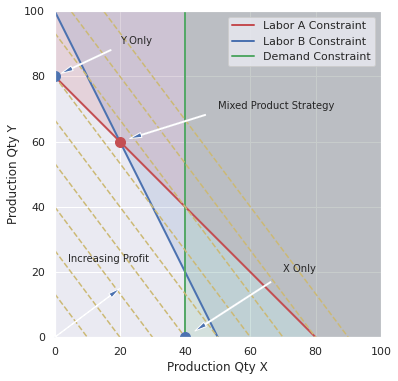

In [55]:
plt.figure(figsize=(6, 6))
plt.subplot(111, aspect='equal')
plt.axis([0, 100, 0, 100])
plt.xlabel('Production Qty X')
plt.ylabel('Production Qty Y')

# Labor A constraint
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# Labor B constraint
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# Demand constraint
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

# Optimum
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), 
             arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.plot(0, 80, 'b.', ms=20)
plt.annotate('Y Only', xy=(0, 80), xytext=(20, 90), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.plot(40, 0, 'b.', ms=20)
plt.annotate('X Only', xy=(40, 0), xytext=(70, 20), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.text(4, 23, 'Increasing Profit')
plt.annotate('', xy=(20,15), xytext=(0,0), 
             arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
plt.savefig(fname, bbox_inches='tight')

# 🍺🤔 ➡ 🍻😀 Pivko Blending problem

### Problem Statement (Jenchura, 2017)

A brewery receives an order for 100 gallons of 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV that cost USD 0.32 per gallon to make, and beer B that is 3.7% ABV and cost USD 0.25 per gallon. Water could also be used as a blending agent at a cost of USD 0.05 per gallon. Find the minimum cost blend that meets the customer requirements.

### Representing Problem Data as a Python Dictionary

We will use this problem as an opportunity to write a Python function that accepts data on raw materials and customer specifications to produce the lowest cost blend.

The first step is to represent the problem data in a generic manner that could, if needed, be extended to include additional blending components.  Here we use a dictionary of materials, each key denoting a blending agent. For each key there is a sub-dictionary containing attributes of each blending component.

In [56]:
data = {
    'Okhota': {'abv': 0.045, 'cost': 0.32},
    'Baltika': {'abv': 0.037, 'cost': 0.25},
    'Water': {'abv': 0.000, 'cost': 0.05},
}

### Model Formulation

#### Objective Function

If we let subscript $c$ denote a blending component from the set of blending components $C$, and denote the volume of $c$ used in the blend as $x_c$, the cost of the blend is

\begin{align}
\mbox{cost} & = \sum_{c\in C} x_c P_c
\end{align}

where $P_c$ is the price per unit volume of $c$. Using the Python data dictionary defined above, the price $P_c$ is given by `data[c]['cost']`.


#### Volume Constraint

The customer requirement is produce a total volume $V$. Assuming ideal solutions, the constraint is given by

\begin{align}
V &  = \sum_{c\in C} x_c
\end{align}

where $x_c$ denotes the volume of component $c$ used in the blend.


#### Product Composition Constraint

The product composition is specified as 4% alchohol by volume. Denoting this as $\bar{A}$, the constraint may be written as

\begin{align}
\bar{A} & = \frac{\sum_{c\in C}x_c A_c}{\sum_{c\in C} x_c}
\end{align}

where $A_c$ is the alcohol by volume for component $c$. As written, this is a nonlinear constraint. Multiplying both sides of the equation by the denominator yields a linear constraint

\begin{align}
\bar{A}\sum_{c\in C} x_c & = \sum_{c\in C}x_c A_c
\end{align}

A final form for this constraint can be given in either of two versions. In the first version we subtract the left-hand side from the right to give

\begin{align}
0 & = \sum_{c\in C}x_c \left(A_c - \bar{A}\right) & \mbox{ Version 1 of the linear blending constraint}
\end{align}

Alternatively, the summation on the left-hand side corresponds to total volume. Since that is known as part of the problem specification, the blending constraint could also be written as

\begin{align}
\bar{A}V & = \sum_{c\in C}x_c A_c  & \mbox{ Version 2 of the linear blending constraint}
\end{align}

Which should you use? Either will generally work well. The advantage of version 1 is that it is fully specified by a product requirement $\bar{A}$, which is sometimes helpful in writing elegant Python code.


### Implementation in Pyomo

A Pyomo implementation of this blending model is shown in the next cell. The model is contained within a Python function so that it can be more easily reused for additional calculations, or eventually for use by the process operator.

Note that the pyomo library has been imported with the prefix `pyomo`. This is good programming practive to avoid namespace collisions with problem data.

In [57]:
vol = 100
abv = 0.04

def beer_blend(vol, abv, data):
    C = data.keys()
    model = ConcreteModel()
    model.x = Var(C, domain=NonNegativeReals)
    model.cost = Objective(expr = sum(model.x[c]*data[c]['cost'] for c in C))
    model.vol = Constraint(expr = vol == sum(model.x[c] for c in C))
    model.abv = Constraint(expr = 0 == sum(model.x[c]*(data[c]['abv'] - abv) for c in C))

    solver = SolverFactory('cbc')
    solver.solve(model)

    print('Optimal Blend')
    for c in data.keys():
        print('  ', c, ':', model.x[c](), 'gallons')
    print()
    print('Volume = ', model.vol(), 'gallons')
    print('Cost = $', model.cost())
    
beer_blend(vol, abv, data)

Optimal Blend
   Okhota : 37.5 gallons
   Baltika : 62.5 gallons
   Water : 0.0 gallons

Volume =  100.0 gallons
Cost = $ 27.625


# 🚚 Transportation Networks

Keywords: transportation, assignment, cbc usage

This notebook demonstrates the solution of transportation network problems using Pyomo and GLPK. The problem description and data are adapted from Chapter 5 of Johannes Bisschop, ["AIMMS Optimization Modeling", AIMMS B. V., 2014](http://download.aimms.com/aimms/download/manuals/AIMMS3_OM.pdf).


## Imports

In [58]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
    
from pyomo.environ import *

## Background

The prototypical transportation problem deals with the distribution of a commodity from a set of sources to a set of destinations. The object is to minimize total transportation costs while satisfying constraints on the supplies available at each of the sources, and satisfying demand requirements at each of the destinations.

Here we illustrate the transportation problem using an example from Chapter 5 of Johannes Bisschop, "AIMMS Optimization Modeling", Paragon Decision Sciences, 1999. In this example there are two factories and six customer sites located in 8 European cities as shown in the following map. The customer sites are labeled in red, the factories are labeled in blue.

![TransportationNetworksMap.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/TransportationNetworksMap.png?raw=1)

Transportation costs between sources and destinations are given in units of &euro;/ton of goods shipped, and list in the following table along with source capacity and demand requirements.


### Table of transportation costs, customer demand, and available supplies

| Customer\Source | Arnhem [&euro;/ton] | Gouda [&euro;/ton] | Demand [tons]|
| :--: | :----: | :---: | :----: |
| London | n/a | 2.5 | 125 |
| Berlin | 2.5 | n/a | 175 |
| Maastricht | 1.6 | 2.0 | 225 |
| Amsterdam | 1.4 | 1.0 | 250 |
| Utrecht | 0.8 | 1.0 | 225 |
| The Hague | 1.4 | 0.8 | 200 |
| **Supply [tons]** | 550 tons | 700 tons |  |

The situation can be modeled by links connecting a set nodes representing sources to a set of nodes representing customers.

![TransportNet.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/TransportNet.png?raw=1)

For each link we can have a parameter $T[c,s]$ denoting the cost of shipping a ton of goods over the link. What we need to determine is the amount of goods to be shipped over each link, which we will represent as a non-negative decision variable $x[c,s]$.

The problem objective is to minimize the total shipping cost to all customers from all sources. 

$$\mbox{minimize:}\quad \mbox{Cost} = \sum_{c \in Customers}\sum_{s \in Sources} T[c,s] x[c,s]$$

Shipments from all sources can not exceed the manufacturing capacity of the source.

$$\sum_{c \in Customers} x[c,s] \leq \mbox{Supply}[s] \qquad \forall s \in Sources$$

Shipments to each customer must satisfy their demand.

$$\sum_{s\in Sources} x[c,s] = \mbox{Demand}[c] \qquad \forall c \in Customers$$

## Pyomo model

### Data File

In [59]:
Demand = {
   'Lon':   125,        # London
   'Ber':   175,        # Berlin
   'Maa':   225,        # Maastricht
   'Ams':   250,        # Amsterdam
   'Utr':   225,        # Utrecht
   'Hag':   200         # The Hague
}

Supply = {
   'Arn':   600,        # Arnhem
   'Gou':   650         # Gouda
}

T = {
    ('Lon','Arn'): 1000,
    ('Lon','Gou'): 2.5,
    ('Ber','Arn'): 2.5,
    ('Ber','Gou'): 1000,
    ('Maa','Arn'): 1.6,
    ('Maa','Gou'): 2.0,
    ('Ams','Arn'): 1.4,
    ('Ams','Gou'): 1.0,
    ('Utr','Arn'): 0.8,
    ('Utr','Gou'): 1.0,
    ('Hag','Arn'): 1.4,
    ('Hag','Gou'): 0.8
}

### Model file

In [60]:
# Step 0: Create an instance of the model
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
CUS = list(Demand.keys())
SRC = list(Supply.keys())

# Step 2: Define the decision 
model.x = Var(CUS, SRC, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

# Step 4: Constraints
model.src = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])
        
model.dmd = ConstraintList()
for c in CUS:
    model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])
    
results = SolverFactory('cbc').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1705.0
  Upper bound: 1705.0
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 13
  Number of nonzeros: 6
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created 

## Solution

In [61]:
for c in CUS:
    for s in SRC:
        print(c, s, model.x[c,s]())

Lon Arn 0.0
Lon Gou 125.0
Ber Arn 175.0
Ber Gou 0.0
Maa Arn 225.0
Maa Gou 0.0
Ams Arn 0.0
Ams Gou 250.0
Utr Arn 200.0
Utr Gou 25.0
Hag Arn 0.0
Hag Gou 200.0


In [62]:
if 'ok' == str(results.Solver.status):
    print("Total Shipping Costs = ",model.Cost())
    print("\nShipping Table:")
    for s in SRC:
        for c in CUS:
            if model.x[c,s]() > 0:
                print("Ship from ", s," to ", c, ":", model.x[c,s]())
else:
    print("No Valid Solution Found")

Total Shipping Costs =  1705.0

Shipping Table:
Ship from  Arn  to  Ber : 175.0
Ship from  Arn  to  Maa : 225.0
Ship from  Arn  to  Utr : 200.0
Ship from  Gou  to  Lon : 125.0
Ship from  Gou  to  Ams : 250.0
Ship from  Gou  to  Utr : 25.0
Ship from  Gou  to  Hag : 200.0


The solution has the interesting property that, with the exception of Utrecht, customers are served by just one source.

![TransportNet_soln.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/TransportNet_soln.png?raw=1)


## Sensitivity analysis

### Analysis by source

In [63]:
if 'ok' == str(results.Solver.status):
    print("\nSources:")
    print("Source      Capacity   Shipped    Margin")
    for m in model.src.keys():
        s = SRC[m-1]
        print("{0:10s}{1:10.1f}{2:10.1f}{3:10.4f}".format(s,Supply[s],model.src[m](),model.dual[model.src[m]]))
else:
    print("No Valid Solution Found")


Sources:
Source      Capacity   Shipped    Margin
Arn            600.0     600.0   -0.2000
Gou            650.0     600.0    0.0000


The 'marginal' values are telling us how much the total costs will be increased for each one ton increase in the available supply from each source. The optimization calculation says that only 650 tons of the 700 available from Gouda should used for a minimum cost solution, which rules out any further cost reductions by increasing the available supply. In fact, we could decrease the supply Gouda without any harm. The marginal value of Gouda is 0.

The source at Arnhem is a different matter. First, all 550 available tons are being used. Second, from the marginal value we see that the total transportations costs would be reduced by 0.2 Euros for each additional ton of supply.  

The management conclusion we can draw is that there is excess supply available at Gouda which should, if feasible, me moved to Arnhem.

Now that's a valuable piece of information!

### Analysis by customer

In [ ]:
if 'ok' == str(results.Solver.status):    
    print("\nCustomers:")
    print("Customer      Demand   Shipped    Margin")
    for n in model.dmd.keys():
        c = CUS[n-1]
        print("{0:10s}{1:10.1f}{2:10.1f}{3:10.4f}".format(c,Demand[c],model.dmd[n](),model.dual[model.dmd[n]]))
else:
    print("No Valid Solution Found")


Customers:
Customer      Demand   Shipped    Margin
Lon            125.0     125.0    2.5000
Ber            175.0     175.0    2.7000
Maa            225.0     225.0    1.8000
Ams            250.0     250.0    1.0000
Utr            225.0     225.0    1.0000
Hag            200.0     200.0    0.8000


Looking at the demand constraints, we see that all of the required demands have been met by the optimal solution.

The marginal values of these constraints indicate how much the total transportation costs will increase if there is an additional ton of demand at any of the locations. In particular, note that increasing the demand at Berlin will increase costs by 2.7 Euros per ton. This is actually **greater** than the list price for shipping to Berlin which is 2.5 Euros per ton.  Why is this?

To see what's going on, let's resolve the problem with a one ton increase in the demand at Berlin.

We see the total cost has increased from 1715.0 to 1717.7 Euros, an increase of 2.7 Euros just as predicted by the marginal value assocated with the demand constraint for Berlin.

Now let's look at the solution.

Here we see that increasing the demand in Berlin resulted in a number of other changes. This figure shows the changes shipments.

![TransportNet_sens.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/TransportNet_sens.png?raw=1)

* Shipments to Berlin increased from 175 to 176 tons, increasing costs for that link from 437.5 to 440.0, or a net increase of 2.5 Euros.
* Since Arnhem is operating at full capacity, increasing the shipments from Arnhem to Berlin resulted in decreasing the shipments from Arhhem to Utrecht from 150 to 149 reducing those shipping costs from 120.0 to 119.2, a net decrease of 0.8 Euros.
* To meet demand at Utrecht, shipments from Gouda to Utrecht had to increase from 75 to 76, increasing shipping costs by a net amount of 1.0 Euros.
* The net effect on shipping costs is 2.5 - 0.8 + 1.0 = 2.7 Euros.

The important conclusion to draw is that when operating under optimal conditions, a change in demand or supply can have a ripple effect on the optimal solution that can only be measured through a proper sensitivity analysis.

## EXTRA: Exercises

1. Move 50 tons of supply capacity from Gouda to Arnhem, and repeat the sensitivity analysis. How has the situation improved?  In practice, would you recommend this change, or would you propose something different?
2. What other business improvements would you recommend?

# MIP: 🎒 Knapsack

In [64]:
!pip install mip --quiet

     |████████████████████████████████| 48.0 MB 50 kB/s 


![wikipedia](https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg)

As a first example, consider the solution of the 0/1 knapsack problem: given a set $I$ of items, each one with a weight $w_i$ and estimated profit $p_i$, one wants to select a subset with maximum profit such that the summation of the weights of the selected items is less or equal to the knapsack capacity $c$. Considering a set of decision binary variables $x_i$ that receive value $1$ if the $i$-th item is selected, or $0$ if not, the resulting mathematical programming formulation is:

\begin{split}
\textrm{Maximize: }   &  \\
                               &  \sum_{i \in I} p_i \cdot x_i  \\
\textrm{Subject to: } & \\
                               &  \sum_{i \in I} w_i \cdot x_i \leq c  \\
                               &  x_i \in \{0,1\} \,\,\, \forall i \in I
\end{split}



In [65]:
from mip import Model, xsum, maximize, BINARY

p = [10, 13, 18, 31, 7, 15]
w = [11, 15, 20, 35, 10, 33]
c, I = 47, range(len(w))

m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c

m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))

selected items: [0, 3]
